In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi, cos, sin

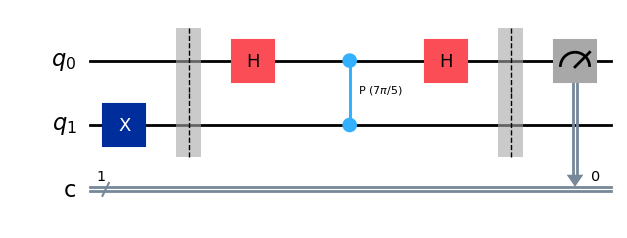

In [2]:
theta = 0.7  # Can be changed to any value between 0 and 1
qc = QuantumCircuit(2, 1)

# Prepare the eigenvector, which is the |1> state
qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

# Draw the circuit
display(qc.draw(output="mpl"))

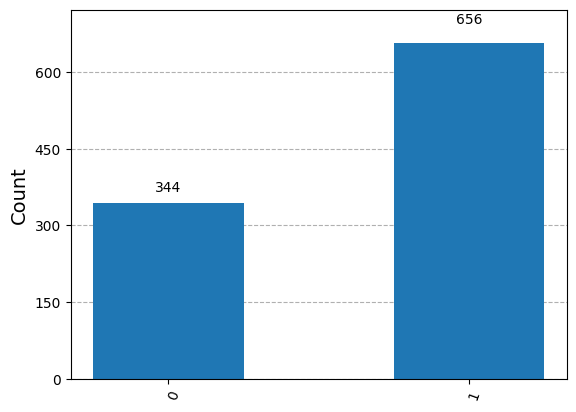

In [4]:
result = AerSimulator().run(qc, shots = 1000).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [5]:
print(f"cos(pi * {theta})**2 = {cos(pi * theta) ** 2:.4f}")
print(f"sin(pi * {theta})**2 = {sin(pi * theta) ** 2:.4f}")

cos(pi * 0.7)**2 = 0.3455
sin(pi * 0.7)**2 = 0.6545


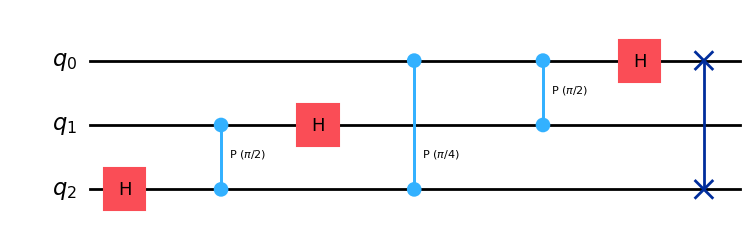

In [9]:
from qiskit.circuit.library import QFT
display(QFT(3).decompose().draw(output="mpl"))

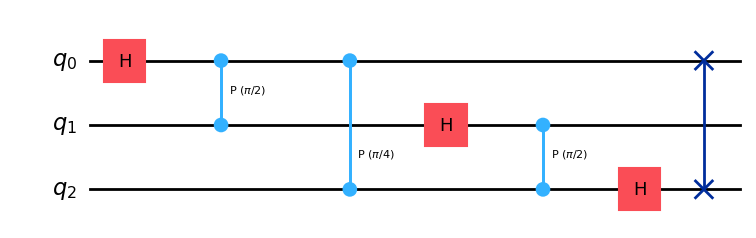

In [10]:
from qiskit import QuantumCircuit
import numpy as np

def qft(n):
    qc = QuantumCircuit(n)
    
    for j in range(n):
        qc.h(j)
        for k in range(j+1, n):
            qc.cp(np.pi/2**(k-j), k, j)  # Controlled Phase Gate
            
    for j in range(n//2):
        qc.swap(j, n-j-1)  # Swap to reverse order
    
    return qc

qc = qft(3)
qc.draw("mpl")  # Visualizing the circuit


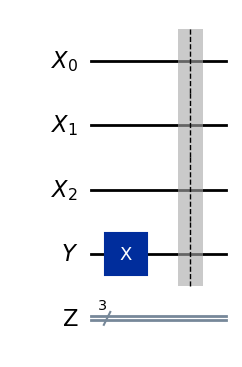

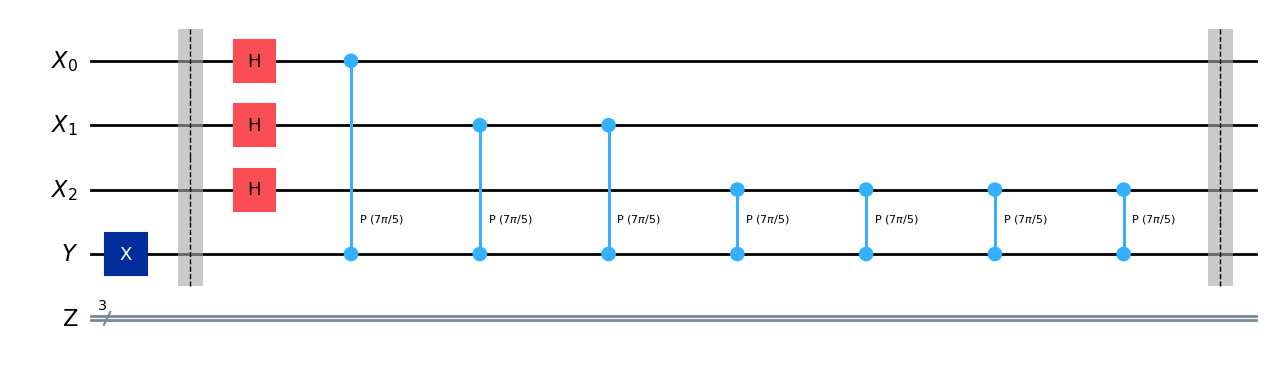

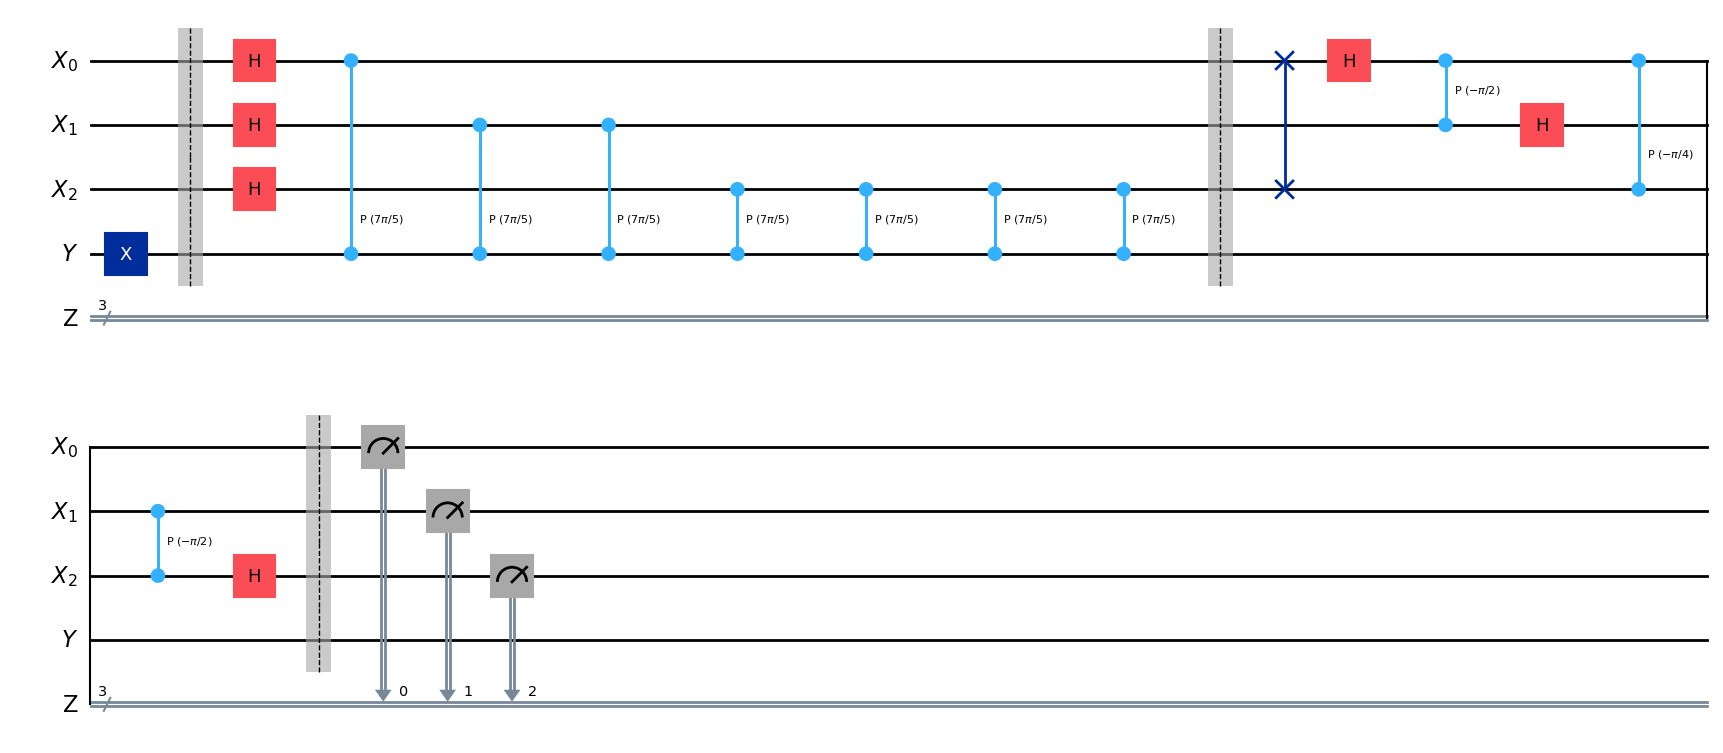

In [27]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

theta = 0.7
m = 3  # Number of control qubits

control = QuantumRegister(m, name="X")
target = QuantumRegister(1, name="Y")
output = ClassicalRegister(m, name="Z")
qc = QuantumCircuit(control, target, output)

# Prepare the eigenvector
qc.x(target)
qc.barrier()

display(qc.draw(output="mpl"))

# Perform phase estimation
for index, qubit in enumerate(control):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target)
qc.barrier()

display(qc.draw(output="mpl"))

# Perform inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True).decompose(),
    inplace=True
)
qc.barrier()

# Measure everything
qc.measure(range(m), range(m))

display(qc.draw(output="mpl"))

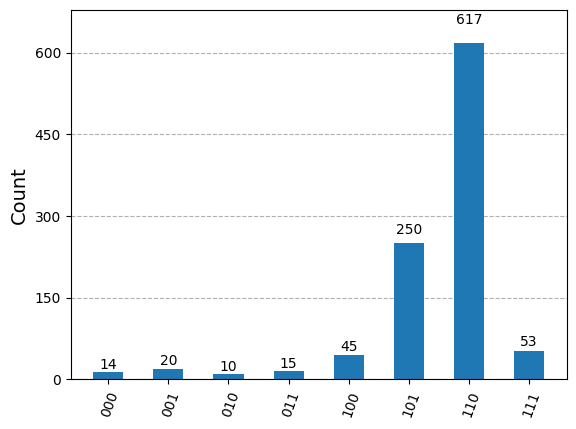

In [25]:
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [28]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import numpy as np
from math import gcd, floor, log
from fractions import Fraction
import random

In [30]:
def mod_mult_gate(b,N):
    if gcd(b,N)>1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        U = np.full((2**n,2**n),0)
        for x in range(N): U[b*x % N][x] = 1
        for x in range(N,2**n): U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

In [31]:
def order_finding_circuit(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n

        control = QuantumRegister(m, name = "X")
        target = QuantumRegister(n, name = "Y")
        output = ClassicalRegister(m, name = "Z")
        circuit = QuantumCircuit(control, target, output)

        # Initialize the target register to the state |1>
        circuit.x(m)

        # Add the Hadamard gates and controlled versions of the
        # multiplication gates
        for k, qubit in enumerate(control):
            circuit.h(k)
            b = pow(a,2**k,N)
            circuit.compose(
                mod_mult_gate(b,N).control(),
                qubits = [qubit] + list(target),
                inplace=True)

        # Apply the inverse QFT to the control register
        circuit.compose(
            QFT(m, inverse=True),
            qubits=control,
            inplace=True)

        # Measure the control register
        circuit.measure(control, output)

        return circuit

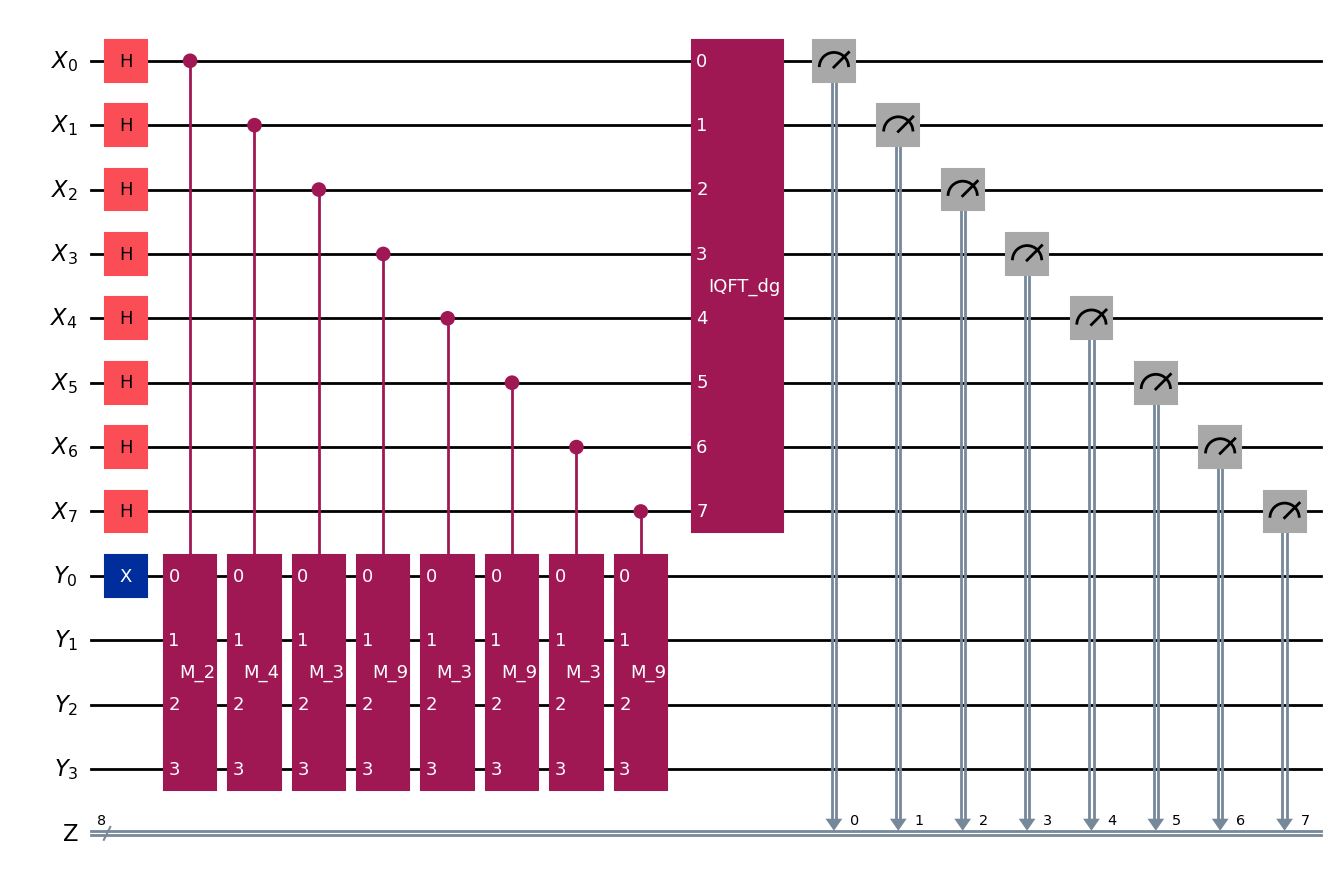

In [36]:
order_finding_circuit(2,13).draw(output = "mpl")

In [33]:
def find_order(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n
        circuit = order_finding_circuit(a,N)
        transpiled_circuit = transpile(circuit,AerSimulator())

        while True:
            result = AerSimulator().run(
                transpiled_circuit,
                shots=1,
                memory=True).result()
            y = int(result.get_memory()[0],2)
            r = Fraction(y/2**m).limit_denominator(N).denominator
            if pow(a,r,N)==1: break
        return r

In [37]:
N = 13
a = 2
print(f"The order of {a} modulo {N} is {find_order(a,N)}.")

The order of 2 modulo 13 is 12.


In [45]:
N = 29

FACTOR_FOUND = False

# First we'll check to see if N is even or a nontrivial power.
# Order finding won't help for factoring a *prime* power, but
# we can easily find a nontrivial factor of *any* nontrivial
# power, whether prime or not.

if N % 2 == 0:
    print("Even number")
    d = 2
    FACTOR_FOUND = True
else:
    for k in range(2,round(log(N,2))+1):
        d = int(round(N ** (1/k)))
        if d**k == N:
            FACTOR_FOUND = True
            print("Number is a power")
            break

# Now we'll iterate until a nontrivial factor of N is found.

while not FACTOR_FOUND:
    a = random.randint(2,N-1)
    d = gcd(a,N)
    if d>1:
        FACTOR_FOUND = True
        print(f"Lucky guess of {a} modulo {N}")
    else:
        r = find_order(a,N)
        print(f"The order of {a} modulo {N} is {r}")
        if r % 2 == 0:
            x = pow(a,r//2,N) - 1
            d = gcd(x,N)
            if d>1: FACTOR_FOUND = True

print(f"Factor found: {d}")

The order of 10 modulo 29 is 28
The order of 15 modulo 29 is 28
The order of 10 modulo 29 is 28
The order of 27 modulo 29 is 28
The order of 12 modulo 29 is 4
The order of 27 modulo 29 is 28
The order of 21 modulo 29 is 28
The order of 13 modulo 29 is 14
The order of 14 modulo 29 is 28
The order of 28 modulo 29 is 2
The order of 12 modulo 29 is 4
The order of 25 modulo 29 is 7
The order of 13 modulo 29 is 14
The order of 6 modulo 29 is 14
The order of 7 modulo 29 is 7
The order of 27 modulo 29 is 28
The order of 27 modulo 29 is 28
The order of 8 modulo 29 is 28
The order of 10 modulo 29 is 28
The order of 20 modulo 29 is 7
The order of 16 modulo 29 is 7
The order of 11 modulo 29 is 28
The order of 15 modulo 29 is 28
The order of 24 modulo 29 is 7
The order of 5 modulo 29 is 14
The order of 26 modulo 29 is 28
The order of 4 modulo 29 is 14
The order of 18 modulo 29 is 28
The order of 12 modulo 29 is 4
The order of 26 modulo 29 is 28
The order of 14 modulo 29 is 28
The order of 3 modulo 

KeyboardInterrupt: 